### Preliminaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [2]:
#Load in data set
ABBdata = pd.read_csv("C:/Users/zhaoy/Documents/ECON611_ML/AirBnB price pred.csv")
#View data
ABBdata.head()

C:\Users\zhaoy\anaconda3\envs\tf2\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,city
0,38585,Charming Victorian home - twin beds + breakfast,165529,Evelyne,NaN,28804,35.65146,-82.62792,Private room,60,1,138,16/02/20,1.14,1,0,Asheville
1,80905,French Chic Loft,427027,Celeste,NaN,28801,35.59779,-82.55540,Entire home/apt,470,1,114,7/9/2020,1.03,11,288,Asheville
2,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,75,30,89,30/11/19,0.81,2,298,Asheville
3,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,1,267,22/09/20,2.39,5,0,Asheville
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,30,58,19/10/15,0.52,1,0,Asheville


In [3]:
#Places with more minimum nights than 365 are not short term listings
ABBdata = ABBdata[ABBdata['minimum_nights']<365]

#Get Unique City names
cities = ABBdata.city.unique()
#Make cities into a dataframe that we can work with
cities = pd.DataFrame(cities, columns =['CityName'])

#Create a set of city indicators
for i, row in enumerate(cities.values):
    citydum = cities.CityName[i]==ABBdata.city
    colname = cities.CityName[i]
    ABBdata[colname]=citydum

#Use log price - need to add 1 before doing so because ln(0) doesnt exist
ABBdata['price']=np.log(ABBdata['price']+1)

#Create substring
sub = "Entire"
#I call this "sub" because I will search for this substring
ABBdata["Entire"]= ABBdata["room_type"].str.find(sub, 0)

#Create a "true" or "false" that it is the entire place
ABBdata["Entire"] = ABBdata.Entire>=0
#Assign 1 to "True" and 0 to "False"
ABBdata["Entire"] = ABBdata["Entire"].astype(int)

#look at owner descriptions. Transform everything to lower case to make text easier to process
# (the operators we use are case-sensitive) (PRE PROCESSING)
ABBdata['name'] = ABBdata['name'].str.lower()

#The word "minutes" is often used to say that the listing is very close to something desirable, like downtown, museums etc.
sub = "minutes"
ABBdata["Minutes"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Minutes"] = ABBdata.Minutes>=0
ABBdata["Minutes"]=ABBdata["Minutes"].astype(int)
#CLeanliness of the place, etc.
sub = "clean"
ABBdata["Clean"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Clean"] = ABBdata.Clean>=0
ABBdata["Clean"] = ABBdata["Clean"].astype(int)
sub = "convenient"
ABBdata["Convenient"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Convenient"] = ABBdata.Convenient>=0
ABBdata["Convenient"] = ABBdata["Convenient"].astype(int)
sub = "charm"
ABBdata["Charm"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Charm"] = ABBdata.Charm>=0
ABBdata["Charm"] = ABBdata["Charm"].astype(int)
sub = "cozy"
ABBdata["Cozy"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Cozy"] = ABBdata.Cozy>=0
ABBdata["Cozy"] = ABBdata["Cozy"].astype(int)
sub = "comf"
ABBdata["Comfortable"]= ABBdata["name"].str.find(sub, 0)
ABBdata["Comfortable"] = ABBdata.Comfortable>=0
ABBdata["Comfortable"] = ABBdata["Comfortable"].astype(int)

In [4]:
ABBdata.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'city', 'Asheville', 'Austin', 'Boston',
       'Broward County', 'Cambridge', 'Chicago', 'Clark County', 'Columbus',
       'Denver', 'Hawaii', 'Jersey City', 'Los Angeles', 'Nashville',
       'New Orleans', 'New York City', 'Oakland', 'Pacific Grove', 'Portland',
       'Rhode Island', 'Salem', 'San Clara Country', 'San Diego',
       'San Francisco', 'San Mateo County', 'Santa Cruz County', 'Seattle',
       'Twin Cities MSA', 'Washington D.C.', 'Entire', 'Minutes', 'Clean',
       'Convenient', 'Charm', 'Cozy', 'Comfortable'],
      dtype='object')

In [5]:
#Drop Columns we aren't going to use
ABBdata_class = ABBdata.drop(['id', 'name', 'host_name', 'city', 'neighbourhood', 'host_id', 'neighbourhood_group', 'latitude', 'longitude', 'room_type', 'last_review'], axis=1)
ABBdata_class = ABBdata_class.dropna(axis=0, how='any')

#Sort data on something other than city name - sorting on city name means for some folds we wont have any observations for some cities
ABBdata_class = ABBdata_class.sort_values(by=['price'])

#Create our Y and X data, which we will input into sci-kit learn
ydata = pd.DataFrame(ABBdata_class.price)
xdata = pd.DataFrame(ABBdata_class)
xdata = xdata.drop(['price'], axis=1)

In [6]:
xdata = xdata.reset_index(drop=True)
xdata

,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,Asheville,Austin,Boston,Broward County,Cambridge,...,Seattle,Twin Cities MSA,Washington D.C.,Entire,Minutes,Clean,Convenient,Charm,Cozy,Comfortable
0,2,143,4.21,24,171,False,False,False,False,False,...,False,False,False,0,0,0,0,0,0,0
1,1,16,0.45,3,0,False,False,False,False,False,...,False,False,False,0,0,0,0,0,0,0
2,2,118,3.55,24,0,False,False,False,False,False,...,False,False,False,0,0,0,0,0,0,0
3,2,97,2.91,24,163,False,False,False,False,False,...,False,False,False,0,0,0,0,0,0,0
4,1,2,0.24,5,0,False,False,False,False,False,...,False,False,False,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177259,2,4,0.62,4,258,True,False,False,False,False,...,False,False,False,1,0,0,0,0,0,0
177260,3,5,0.22,166,0,False,False,False,False,False,...,False,False,False,1,0,0,0,1,0,0
177261,3,4,0.10,166,0,False,False,False,False,False,...,False,False,False,1,0,0,0,0,0,0
177262,2,5,1.55,4,253,True,False,False,False,False,...,False,False,False,1,0,0,0,0,0,0


In [7]:
#Convert the pandas data frame to a numpy array to use scikit learn
xdatan = xdata.values
ydatan = ydata.values

In [35]:
# Initial model evaluation
scores = cross_val_score(LinearRegression(), xdatan, ydatan, cv=5, scoring='neg_mean_squared_error')
scores = -scores
print("Cross Validation")
print("Average MSE %0.5f std of MSE %0.5f" % (scores.mean(), scores.std()))

Cross Validation
Average MSE 0.66188 std of MSE 0.58572


### 1(a)

In [9]:
# Keeping certain columns 
ABBdata_new = ABBdata.drop(['id', 'name', 'host_name', 'city', 'neighbourhood', 'host_id', 'neighbourhood_group', 'room_type'], axis=1)
ABBdata_new = ABBdata_new.dropna(axis=0, how='any')

#Sort data on something other than city name - sorting on city name means for some folds we wont have any observations for some cities
ABBdata_new = ABBdata_new.sort_values(by=['price'])

#Create our Y and X data, which we will input into sci-kit learn
ydata_new = pd.DataFrame(ABBdata_new.price)
xdata_new = pd.DataFrame(ABBdata_new)
xdata_new = xdata_new.drop(['price'], axis=1)

In [10]:
xdata_new.last_review.unique()

array(['26/05/20', '16/11/18', '30/04/20', ..., '24/10/12', '11/3/2014',
       '17/02/15'], dtype=object)

In [11]:
# Find the most recent date

most_recent_review = xdata_new['last_review'].max()
most_recent_review

'9/9/2020'

In [12]:
# Convert 'last_review' column into datetime object
xdata_new['last_review'] = pd.to_datetime(xdata_new['last_review'], dayfirst=True, errors='coerce')

# Find the latest date
latest_date = xdata_new['last_review'].max()

# Setting a cutoff date to 2 years before the most recent review
cutoff_date = latest_date - pd.DateOffset(years=2)

# Create a dummy variable column
xdata_new['recent_review'] = (xdata_new['last_review'] > cutoff_date).astype(int)


In [13]:
xdata_new.recent_review

202232    1
204886    1
202243    1
202242    1
153759    1
         ..
1846      1
185699    1
185680    1
1845      1
185734    1
Name: recent_review, Length: 177264, dtype: int32

In [14]:
xdata_new.columns

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'last_review', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Asheville', 'Austin', 'Boston', 'Broward County',
       'Cambridge', 'Chicago', 'Clark County', 'Columbus', 'Denver', 'Hawaii',
       'Jersey City', 'Los Angeles', 'Nashville', 'New Orleans',
       'New York City', 'Oakland', 'Pacific Grove', 'Portland', 'Rhode Island',
       'Salem', 'San Clara Country', 'San Diego', 'San Francisco',
       'San Mateo County', 'Santa Cruz County', 'Seattle', 'Twin Cities MSA',
       'Washington D.C.', 'Entire', 'Minutes', 'Clean', 'Convenient', 'Charm',
       'Cozy', 'Comfortable', 'recent_review'],
      dtype='object')

In [15]:
# Dropping the old column
xdata_new = xdata_new.drop('last_review',axis=1)
xdata_new.columns

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'Asheville', 'Austin', 'Boston', 'Broward County',
       'Cambridge', 'Chicago', 'Clark County', 'Columbus', 'Denver', 'Hawaii',
       'Jersey City', 'Los Angeles', 'Nashville', 'New Orleans',
       'New York City', 'Oakland', 'Pacific Grove', 'Portland', 'Rhode Island',
       'Salem', 'San Clara Country', 'San Diego', 'San Francisco',
       'San Mateo County', 'Santa Cruz County', 'Seattle', 'Twin Cities MSA',
       'Washington D.C.', 'Entire', 'Minutes', 'Clean', 'Convenient', 'Charm',
       'Cozy', 'Comfortable', 'recent_review'],
      dtype='object')

In [39]:
#Convert the pandas data frame to a numpy array to use scikit learn
xdatan_new = xdata_new.values
ydatan_new = ydata_new.values
# New model evaluation
scores_new = cross_val_score(LinearRegression(), xdatan_new, ydatan_new, cv=5, scoring='neg_mean_squared_error')
scores_new = -scores_new
print("Cross Validation")
print("Average MSE %0.5f std of MSE %0.5f" % (scores_new.mean(), scores_new.std()))

Cross Validation
Average MSE 0.65854 std of MSE 0.58216


In [37]:
difference_mse = scores.mean() - scores_new.mean()
difference_std = scores.std() - scores_new.std()

print(f"Average MSE reduced by {difference_mse:.5f}")
print(f"Std of MSE reduced by {difference_std:.5f}")

Average MSE reduced by 0.00334
Std of MSE reduced by 0.00357


In [40]:
# New model evaluation by changing cross-validation to 10 fold
scores_new2 = cross_val_score(LinearRegression(), xdatan_new, ydatan_new, cv=10, scoring='neg_mean_squared_error')
scores_new2 = -scores_new2
print("Cross Validation")
print("Average MSE %0.5f std of MSE %0.5f" % (scores_new2.mean(), scores_new2.std()))

Cross Validation
Average MSE 0.50655 std of MSE 0.63763


In [41]:
difference_mse2 = scores.mean() - scores_new2.mean()
difference_std2 = scores.std() - scores_new2.std()

print(f"Average MSE reduced by {difference_mse2:.5f}")
print(f"Std of MSE reduced by {difference_std2:.5f}")

Average MSE reduced by 0.15533
Std of MSE reduced by -0.05190


#### By keeping the "last_review" column in the data and creating a new indicator column "recent_review", indicating whether a listing has received reviews in recent years, the new model has improved slightly by a 0.00334 reduction in terms of average mean squared error. Standard deviation of the average mse has also reduced slightly by 0.00357. 

#### Altering the method of performance evaluation using 10 fold cross-validation instead of 5 reduced average mse by 0.15533, however there is an increase in the standard deviation of the average mse of 0.05190, which means that the model's performance has improved in terms of accuracy

##### *Testing code*

In [34]:
# Split the data into training and testing sets
#X_train, X_test, Y_train, Y_test = train_test_split(xdatan_new, ydatan_new.ravel(), test_size=0.2, random_state=42)

# Fit the Linear Regression model on the training data
#linear_reg = LinearRegression().fit(X_train, Y_train)

# Create a DataFrame to view the coefficients for each feature
#coefficients = pd.DataFrame(linear_reg.coef_, index=xdata_new.columns, columns=['Coefficient'])

#print(coefficients)

# Identify features that have the least predictive power
#threshold = 0.0003
#low_impact_features = coefficients[abs(coefficients['Coefficient']) < threshold].index.tolist()

# Dropping the features from the original dataset
#xdata_filtered = xdata.drop(columns=low_impact_features)

# Convert to NumPy array
#xdatan_filtered = xdata_filtered.values

# Split the data into training and testing sets
#X_train2, X_test2, Y_train2, Y_test2 = train_test_split(xdatan_filtered, ydatan.ravel(), test_size=0.2, random_state=42)

# Fit the Linear Regression model on the training data
#linear_reg = LinearRegression().fit(X_train2, Y_train2)

# Predict on the testing set
#Y_pred = linear_reg.predict(X_test2)
#mse = mean_squared_error(Y_test2, Y_pred)
#mse

#linear_reg1 = LinearRegression().fit(X_train, Y_train)
#Y_pred1 = linear_reg1.predict(X_test)
#mse1 = mean_squared_error(Y_test, Y_pred1)
#mse1

# Evaluate model performance
#scores_new2 = cross_val_score(LinearRegression(), xdatan_filtered, ydatan.ravel(), cv=5, scoring='neg_mean_squared_error')
#scores_new2 = -scores_new2
#print("Cross Validation")
#print("Average MSE %0.5f std of MSE %0.2f" % (scores_new2.mean(), scores_new2.std()))

#r_squared_scores = cross_val_score(LinearRegression(), xdatan, ydatan.ravel(), cv=5, scoring='r2')
#r_squared_scores_new = cross_val_score(LinearRegression(), xdatan_new, ydatan_new.ravel(), cv=5, scoring='r2')
#print(r_squared_scores.mean())
#print(r_squared_scores_new.mean())

### 1(b)

In [107]:
from sklearn.linear_model import RidgeCV

# Define a range of lambda values
lambdas = np.logspace(-6, 6, 13)

# Initialize RidgeCV with the lambda values and cross-validation parameters
ridge_cv = RidgeCV(alphas=lambdas, cv=5, scoring='neg_mean_squared_error')

# Fit the model
ridge_cv.fit(xdatan_new, ydatan_new.ravel())

# Find the optimal lambda value
optimal_lambda = ridge_cv.alpha_
print(f"Optimal lambda: {optimal_lambda}")


Optimal lambda: 1e-06


In [108]:
# Apply ridge regression
lambda_value = optimal_lambda
ridge_reg = Ridge(alpha=lambda_value)
ridge_reg.fit(xdatan_new, ydatan_new.ravel())

# Extract the coefficients
ridge_coefficients = ridge_reg.coef_

In [109]:
# Fitting a linear regression to extract the coefficients
regr = linear_model.LinearRegression(fit_intercept=True)
regr.fit(xdatan_new, ydatan_new)

# Extract the coefficients
regr_coefficients = regr.coef_

In [110]:
# Flattern the array to 1D format
ridge_coefficients = ridge_coefficients.flatten()
regr_coefficients = regr_coefficients.flatten()

In [111]:
# Collecting feature names
feature_names = xdata_new.columns

# Initialize the DataFrame with an index
coef_compare = pd.DataFrame(index=feature_names)

coef_compare['Linear Regression'] = regr_coefficients
coef_compare['Ridge Regression'] = ridge_coefficients
#coef_compare

In [112]:
# Calculate the difference in absolute values between linear and ridge coefficients
coefficients_difference = np.abs(regr_coefficients) - np.abs(ridge_coefficients)

## Identify coeffiicents that shrunk
shrink_indicator = coefficients_difference > 0

# Display shrunk coefficients
# Initialize a DataFrame to compare coefficients
coef_compare = pd.DataFrame({
    'Feature': feature_names,
    'Linear Regression': regr_coefficients,
    'Ridge Regression': ridge_coefficients,
    'Difference': coefficients_difference
})

# Filter to only show coefficients that have shrunk
shrunk_coefs = coef_compare[shrink_indicator].sort_values(by='Difference', ascending=False)

In [113]:
new_shrunk_coefs= shrunk_coefs.reset_index(drop=True)
new_shrunk_coefs

,Feature,Linear Regression,Ridge Regression,Difference
0,Hawaii,-10.630897,-10.630844,5.290021e-05
1,San Diego,-2.895231,-2.895200,3.087090e-05
2,Pacific Grove,-2.719344,-2.719313,3.065757e-05
3,Los Angeles,-3.051492,-3.051461,3.062153e-05
4,Santa Cruz County,-2.927341,-2.927311,3.046538e-05
5,San Mateo County,-3.106599,-3.106569,3.029751e-05
6,San Clara Country,-3.265639,-3.265609,3.026857e-05
7,San Francisco,-2.978763,-2.978733,3.022275e-05
8,Oakland,-3.415838,-3.415808,3.012290e-05
9,Clark County,-2.306148,-2.306120,2.827691e-05


In [117]:
## Identify coeffiicents that didn't shrink
not_shrink_indicator = coefficients_difference <= 0

# Display shrunk coefficients
# Initialize a DataFrame to compare coefficients
coef_compare2 = pd.DataFrame({
    'Feature': feature_names,
    'Linear Regression': regr_coefficients,
    'Ridge Regression': ridge_coefficients,
    'Difference': coefficients_difference
})

# Filter to only show coefficients that didn't shrink
not_shrink_coefs = coef_compare2[not_shrink_indicator].sort_values(by='Difference', ascending=False)

In [118]:
not_shrink_coefs.reset_index(drop=True)

,Feature,Linear Regression,Ridge Regression,Difference
0,reviews_per_month,-0.065642,-0.065642,-5.503865e-10
1,recent_review,-0.061542,-0.061542,-1.751222e-09
2,Cozy,-0.231203,-0.231203,-2.290154e-09
3,Comfortable,-0.159372,-0.159372,-3.984152e-09
4,Convenient,-0.113346,-0.113346,-6.030825e-09
5,Entire,0.843385,0.843385,-7.490990e-09
6,Clean,-0.088548,-0.088548,-8.505464e-09
7,Cambridge,5.703653,5.703661,-7.676819e-06
8,Boston,5.519504,5.519512,-7.692629e-06
9,Rhode Island,5.553417,5.553425,-8.227974e-06


In [131]:
# Evaluate Ridge Regression model
ridge_scores = cross_val_score(Ridge(alpha=lambda_value), xdatan_new, ydatan_new, cv=5, scoring='neg_mean_squared_error')

# Compare the average MSE scores and standard deviation of MSE
linear_mse_average = scores_new.mean()
ridge_mse_average = -np.mean(ridge_scores)

linear_std_mse = scores_new.std()
ridge_std_mse = np.std(ridge_scores)

print(f"Linear Regression Average MSE and std of MSE: {linear_mse_average}, {linear_std_mse}")
print(f"Ridge Regression Average MSE and std of MSE: {ridge_mse_average}, {ridge_std_mse}")


Linear Regression Average MSE and std of MSE: 0.6585390090485586, 0.5821588571675149
Ridge Regression Average MSE and std of MSE: 0.6585390124187008, 0.5821588650754235


### 1(c)

In [119]:
from sklearn.linear_model import LassoCV

# Initialize and fit the LassoCV model
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000)
lasso_cv.fit(xdatan_new, ydatan_new.ravel())

# Finding the optimal lambda value
optimal_lambda_lasso = lasso_cv.alpha_
print(f"Optimal lambda for Lasso: {optimal_lambda_lasso}")


Optimal lambda for Lasso: 0.012820117021768074


In [126]:
# Coefficients from the Lasso model
lasso_coefficients = lasso_cv.coef_

# Creating a dataframe to compare coefficients
coef_compare = pd.DataFrame({
    'Linear Regression': regr_coefficients,
    'Lasso Regression': lasso_coefficients
}, index=feature_names)

coef_compare['Lasso Zero'] = (coef_compare['Lasso Regression'] == 0)
zero_features = coef_compare[coef_compare['Lasso Zero']]
zero_features

,Linear Regression,Lasso Regression,Lasso Zero
Asheville,2.734725,0.0,True
Austin,-0.228571,0.0,True
Boston,5.519504,0.0,True
Broward County,1.929791,-0.0,True
Cambridge,5.703653,0.0,True
Chicago,2.493901,-0.0,True
Clark County,-2.306148,-0.0,True
Columbus,3.076937,-0.0,True
Denver,-0.404231,-0.0,True
Hawaii,-10.630897,-0.0,True


In [132]:
# Evaluate Lasso model with the optimal alpha
lasso_scores = cross_val_score(Lasso(alpha=optimal_lambda_lasso, max_iter=10000), xdatan_new, ydatan_new.ravel(), cv=5, scoring='neg_mean_squared_error')

# Compare average MSE
lasso_mse_average = -np.mean(lasso_scores)
lasso_std_mse = np.std(lasso_scores)
print(f"Lasso Regression Average MSE and std of MSE: {lasso_mse_average}, {lasso_std_mse}")
print(f"Linear Regression Average MSE and std of MSE: {linear_mse_average}, {linear_std_mse}")
print(f"Ridge Regression Average MSE and std of MSE: {ridge_mse_average}, {ridge_std_mse}")


Lasso Regression Average MSE and std of MSE: 0.7029705243183078, 0.6341522955860689
Linear Regression Average MSE and std of MSE: 0.6585390090485586, 0.5821588571675149
Ridge Regression Average MSE and std of MSE: 0.6585390124187008, 0.5821588650754235


### 1(d)

In [138]:
# Fit a decision tree regressor
tree_regressor = DecisionTreeRegressor(random_state=42, max_depth=10)
tree_regressor.fit(xdatan_new, ydatan_new.ravel())

# Get the pruning path
path = tree_regressor.cost_complexity_pruning_path(xdatan_new, ydatan_new.ravel())
alphas, impurities = path.ccp_alphas, path.impurities


In [141]:
# Find the optimal alpha using cross-validation
alphas = np.logspace(-4, 4, 5)
cv_mse = []
for alpha in alphas:
    tree_regressor = DecisionTreeRegressor(random_state=42, ccp_alpha=alpha, max_depth=10)
    scores = cross_val_score(tree_regressor, xdatan_new, ydatan_new.ravel(), cv=5, scoring='neg_mean_squared_error')
    cv_mse.append(-np.mean(scores))

# Select the alpha with the lowest MSE
optimal_alpha = alphas[np.argmin(cv_mse)]
print(f"Optimal alpha: {optimal_alpha}")

Optimal alpha: 0.0001


In [143]:
# Fit the decision tree regressor with the optimal alpha
optimal_tree_regressor = DecisionTreeRegressor(random_state=42, ccp_alpha=optimal_alpha, max_depth=10)
optimal_tree_regressor.fit(xdatan_new, ydatan_new.ravel())

DecisionTreeRegressor(ccp_alpha=0.0001, max_depth=10, random_state=42)

In [145]:
# Evaluate the optimal tree regressor
tree_scores = cross_val_score(optimal_tree_regressor, xdatan_new, ydatan_new.ravel(), cv=5, scoring='neg_mean_squared_error')
tree_mse = -np.mean(tree_scores)
tree_std_mse = np.std(tree_scores)

print(f"Decision Tree Regression Average MSE and std of MSE: {tree_mse}, {tree_std_mse}")
print(f"Lasso Regression Average MSE and std of MSE: {lasso_mse_average}, {lasso_std_mse}")
print(f"Linear Regression Average MSE and std of MSE: {linear_mse_average}, {linear_std_mse}")
print(f"Ridge Regression Average MSE and std of MSE: {ridge_mse_average}, {ridge_std_mse}")

Decision Tree Regression Average MSE and std of MSE: 0.6615254177135393, 0.5586202951412677
Lasso Regression Average MSE and std of MSE: 0.7029705243183078, 0.6341522955860689
Linear Regression Average MSE and std of MSE: 0.6585390090485586, 0.5821588571675149
Ridge Regression Average MSE and std of MSE: 0.6585390124187008, 0.5821588650754235


#### Linear regression still has the lowest average MSE of 0.6585 among all models, which indicates that linear regression has the best predictive accuracy than other models. Decision tree has a slightly higher MSE than linear regression and Ridge, but it has the lowest standard deviation of the MSE scores (0.5586) than other models, which suggests that this method is more stable and consistent than others when used in this dataset.

### 2(a)

In [151]:
# Setting a random seed 
np.random.seed(42)

# Setting parameters
N = 500 
S = 1000 
mu_u = 0
sigma_u = np.sqrt(3)
mu_2 = 1
sigma_2 = np.sqrt(2)
mu_e = 0
sigma_e = np.sqrt(2)
gamma_0 = 0.5
gamma_1 = 1
beta = np.array([0.5, 1, 1.5]) 

# Data generating process function
def generate_data(N):
    # xi2 ~ N(mu_2, sigma_2^2)
    xi2 = np.random.normal(mu_2, sigma_2, N)
    
    # xi1 = gamma_0 + gamma_1*X2 + e, where e ~ N(mu_e, sigma_e^2)
    xi1 = gamma_0 + gamma_1*xi2 + np.random.normal(mu_e, sigma_e, N)
    
    # Xi = [1, X1, X2]
    Xi = np.vstack([np.ones(N), xi1, xi2]).T
    
    # ui ~ N(mu_u, sigma_u^2)
    ui = np.random.normal(mu_u, sigma_u, N)
    
    # yi = Xi'*beta + ui
    yi = Xi.dot(beta) + ui
    
    return yi, Xi

# Generate a sample
yi, Xi = generate_data(N)



### 2(b)

In [155]:
# # Initialize an empty list to store MSE scores
mse_scores = []

# Set random seed
np.random.seed(42)

for _ in range(S):
    # Generate data
    yi, Xi = generate_data(N)
    
    # Initialize the Linear Regression model
    model_linear = LinearRegression()
    
    # Perform k-fold cross-validation and calculate MSE
    scores = cross_val_score(model_linear, Xi, yi, cv=5, scoring='neg_mean_squared_error')
    
    # Convert scores to positive MSE and calculate the mean
    mse = -scores.mean()
    
    # Append the average MSE of this simulation to the list
    mse_scores.append(mse)

### 2(c)

In [158]:
# Initialize two empty lists
mse_scores_ridge = []  
optimal_lambdas_ridge = []

# Set random seed
np.random.seed(42)

for _ in range(S):
    # Generate data
    yi, Xi = generate_data(N)
    
    # Define a range of lambda values
    lambdas = np.logspace(-6, 6, 13)
    
    # Initialize the RidgeCV model
    model_ridge = RidgeCV(alphas=lambdas, cv=5, scoring='neg_mean_squared_error')
    
    # Fit the model to the data
    model_ridge.fit(Xi, yi)
    
    # Store the optimal lambda
    optimal_lambdas_ridge.append(model_ridge.alpha_)
    
    # Use optimal lambda and calculate MSE
    scores_ridge = cross_val_score(RidgeCV(alphas=[model_ridge.alpha_]), Xi, yi, cv=5, scoring='neg_mean_squared_error')
    
    # Calculate the average mse
    mse_ridge = -scores_ridge.mean()
    
    # Append the average MSE to the list
    mse_scores_ridge.append(mse_ridge)


### 2(d)

In [168]:
# Initialize two empty lists
mse_scores_lasso = []
optimal_lambdas_lasso = [] 

# Set random seed
np.random.seed(42)

for _ in range(S):
    # Generate data
    yi, Xi = generate_data(N)
    
    # Initialize the LassoCV model
    model_lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
    
    # Fit the model to the data
    model_lasso.fit(Xi, yi)
    
    # Store the optimal lambdas
    optimal_lambdas_lasso.append(model_lasso.alpha_)
    
    # Use optimal lambda and calculate MSE
    mse_lasso = np.mean(model_lasso.mse_path_.mean(axis=1))
    
    # Append the average MSE to the list
    mse_scores_lasso.append(mse_lasso)


### 2(e)

In [178]:
len(mse_scores_lasso)

1000

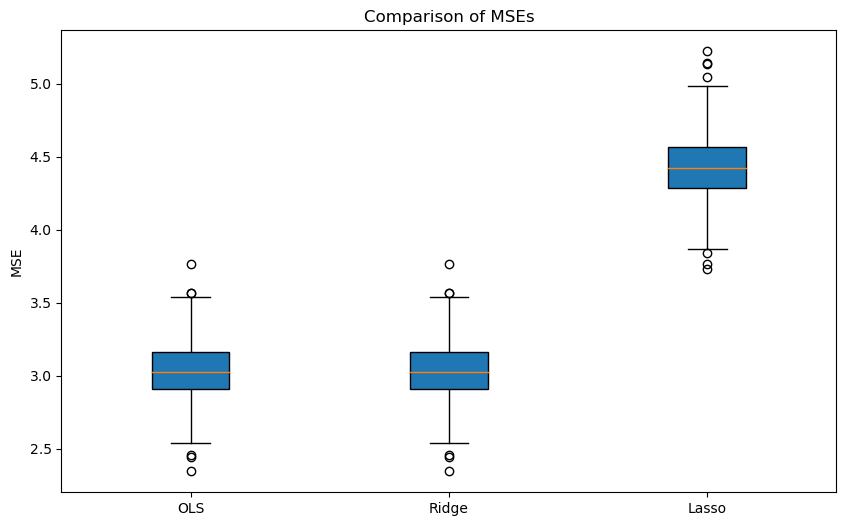

In [186]:
# Create the plot
plt.figure(figsize=(10, 6)) 
plt.boxplot([mse_scores, mse_scores_ridge, mse_scores_lasso], patch_artist=True)

plt.xticks([1, 2, 3], ['OLS', 'Ridge', 'Lasso'])
plt.ylabel('MSE')
plt.title('Comparison of MSEs')
plt.show()


#### Both OLS and Ridge models have the lowest range of MSE scores while Lasso has a higher range of MSE scores, which suggests that both OLS and Ridge have better average predictive performance. Among these two models, the spread of the MSEs from Ridge is slightly smaller than OLS, which suggests that Ridge is more stable with lower variability. Based on the boxplot, Ridge seems to be the best appraoch in this case

### 2(f)

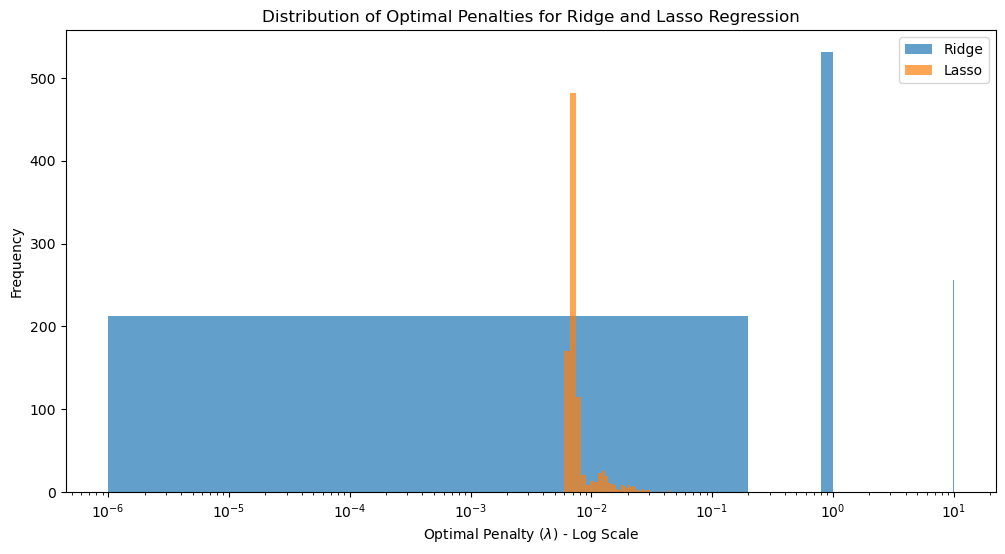

In [195]:
plt.figure(figsize=(12, 6))
plt.hist(optimal_lambdas_ridge, bins=50, alpha=0.7, label='Ridge')
plt.hist(optimal_lambdas_lasso, bins=50, alpha=0.7, label='Lasso')
plt.xscale('log')
plt.title('Distribution of Optimal Penalties for Ridge and Lasso Regression')
plt.xlabel('Optimal Penalty ($\lambda$) - Log Scale')
plt.ylabel('Frequency')
plt.legend()
plt.show()


#### The distribution of optimal $\lambda$ for Ridge varies across a wide range of different values, which means the model's performance on this dataset is very sensitive to the choice of $\lambda$. The large variation in optimal $\lambda$ values also implies that the model finds a different balance between minimizing risidual sum of squares and penalizing coefficients across different simulations. Comparing to Ridge, the distribution of optimal $\lambda$ values for Lasso is more concentrated around $10^-2$ (log scale), which implies less variability across simulations, which also suggests that the process of removing irrelavent features in the Lasso model is more consistent across simulations

### 2(g)

In [196]:
# Setting a random seed 
np.random.seed(42)

# Changing parameters
sigma_e = np.sqrt(0.0001)

# Data generating process function
def generate_data(N):
    # xi2 ~ N(mu_2, sigma_2^2)
    xi2 = np.random.normal(mu_2, sigma_2, N)
    
    # xi1 = gamma_0 + gamma_1*X2 + e, where e ~ N(mu_e, sigma_e^2)
    xi1 = gamma_0 + gamma_1*xi2 + np.random.normal(mu_e, sigma_e, N)
    
    # Xi = [1, X1, X2]
    Xi = np.vstack([np.ones(N), xi1, xi2]).T
    
    # ui ~ N(mu_u, sigma_u^2)
    ui = np.random.normal(mu_u, sigma_u, N)
    
    # yi = Xi'*beta + ui
    yi = Xi.dot(beta) + ui
    
    return yi, Xi

# Generate a sample
yi, Xi = generate_data(N)



In [199]:
# linear regression
mse_scores = []
np.random.seed(42)

for _ in range(S):
    yi, Xi = generate_data(N)
    model_linear = LinearRegression()
    scores = cross_val_score(model_linear, Xi, yi, cv=5, scoring='neg_mean_squared_error')
    mse = -scores.mean()
    mse_scores.append(mse)

In [198]:
# Ridge
mse_scores_ridge = []  
optimal_lambdas_ridge = []
np.random.seed(42)

for _ in range(S):
    yi, Xi = generate_data(N)
    lambdas = np.logspace(-6, 6, 13)
    model_ridge = RidgeCV(alphas=lambdas, cv=5, scoring='neg_mean_squared_error')
    model_ridge.fit(Xi, yi)
    optimal_lambdas_ridge.append(model_ridge.alpha_)
    scores_ridge = cross_val_score(RidgeCV(alphas=[model_ridge.alpha_]), Xi, yi, cv=5, scoring='neg_mean_squared_error')
    mse_ridge = -scores_ridge.mean()
    mse_scores_ridge.append(mse_ridge)

In [200]:
# Lasso
mse_scores_lasso = []
optimal_lambdas_lasso = [] 
np.random.seed(42)

for _ in range(S):
    yi, Xi = generate_data(N)
    model_lasso = LassoCV(cv=5, random_state=42, max_iter=10000)
    model_lasso.fit(Xi, yi)
    optimal_lambdas_lasso.append(model_lasso.alpha_)
    mse_lasso = np.mean(model_lasso.mse_path_.mean(axis=1))
    mse_scores_lasso.append(mse_lasso)

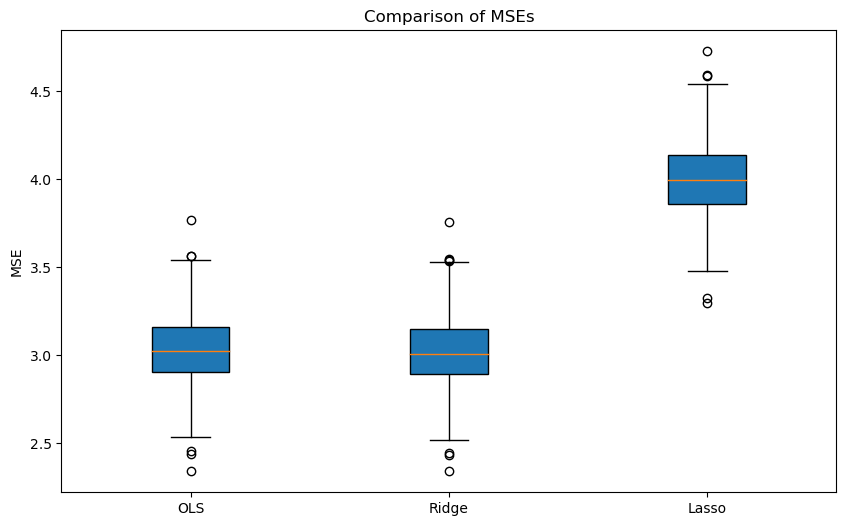

In [201]:
# Create the plot
plt.figure(figsize=(10, 6)) 
plt.boxplot([mse_scores, mse_scores_ridge, mse_scores_lasso], patch_artist=True)

plt.xticks([1, 2, 3], ['OLS', 'Ridge', 'Lasso'])
plt.ylabel('MSE')
plt.title('Comparison of MSEs')
plt.show()

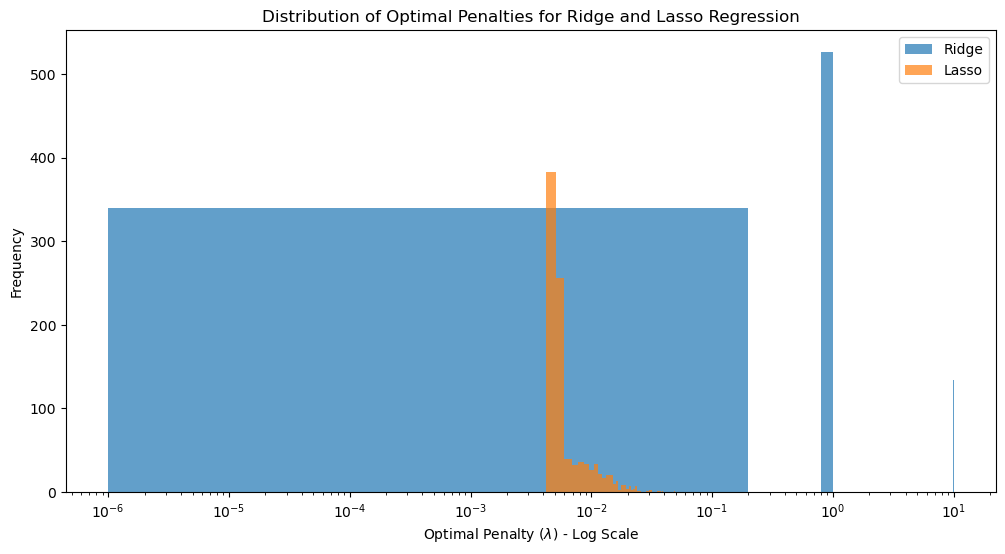

In [202]:
plt.figure(figsize=(12, 6))
plt.hist(optimal_lambdas_ridge, bins=50, alpha=0.7, label='Ridge')
plt.hist(optimal_lambdas_lasso, bins=50, alpha=0.7, label='Lasso')
plt.xscale('log')
plt.title('Distribution of Optimal Penalties for Ridge and Lasso Regression')
plt.xlabel('Optimal Penalty ($\lambda$) - Log Scale')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### 2(h)

In [203]:
def ridge_regression_gradient_descent(X, y, lr=0.01, lambda_param=0.1, iterations=1000):
    m, n = X.shape
    X_b = np.c_[np.ones((m, 1)), X]  # Add bias term
    beta = np.zeros(n + 1)  # Initialize parameters
    
    for iteration in range(iterations):
        gradients = np.zeros(n + 1)
        errors = X_b.dot(beta) - y
        for j in range(n + 1):
            if j == 0:
                gradients[j] = X_b[:, j].dot(errors) / m
            else:
                gradients[j] = X_b[:, j].dot(errors) / m + (lambda_param / m) * beta[j]
        beta = beta - lr * gradients
    
    return beta
